#Data Preprocessing


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np

In [2]:
import torch
torch.cuda.is_available()

True

In [ ]:
# 📂 Définir la liste des fichiers d'images
image_folder_train = ".gitignore/data_split/train"
file_list_train = [os.path.join(image_folder_train, f) for f in os.listdir(image_folder_train) if f.endswith(('png', 'jpg', 'jpeg'))]

In [4]:
image_folder_test = ".gitignore/data_split/test"
file_list_test = [os.path.join(image_folder_test, f) for f in os.listdir(image_folder_test) if f.endswith(('png', 'jpg', 'jpeg'))]

In [5]:
def create_dataframe(file_list, name):
  # 📌 Dictionnaire de mapping des identifiants de races vers labels
  label_mapping = {
      "n02085620": 0, "n02085782": 1, "n02085936": 2, "n02086079": 3,
      "n02086240": 4, "n02086646": 5, "n02086910": 6, "n02087046": 7,
      "n02087394": 8, "n02088094": 9
  }

  # 📊 Extraction des labels
  image_data = []
  for img_path in file_list:
      filename = os.path.basename(img_path)  # Extrait "n02085620_12345.jpg"
      breed_id = filename.split("_")[0]  # Récupère "n02085620"

      label = label_mapping.get(breed_id, -1)  # -1 si inconnu (erreur possible)

      image_data.append([img_path, label])

  # 📊 Création du DataFrame
  df = pd.DataFrame(image_data, columns=["filename", "breed"])

  return {name: df}

In [6]:
result_train = create_dataframe(file_list_train, "df_train")
df_train = result_train["df_train"]
result_test = create_dataframe(file_list_test, "df_test")
df_test = result_test["df_test"]

In [7]:
df_train.shape

(1769, 2)

In [8]:
df_test.shape

(150, 2)

                               filename  breed
0  data_split/train\n02085620_10074.jpg      0
1  data_split/train\n02085620_10131.jpg      0
2  data_split/train\n02085620_10621.jpg      0
3   data_split/train\n02085620_1073.jpg      0
4  data_split/train\n02085620_10976.jpg      0

🔍 Distribution unique des labels :  [0 1 2 3 4 5 6 7 8 9]


C:\Users\mathi\AppData\Local\Temp\ipykernel_24360\3598754738.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, y="breed", order=df_train["breed"].value_counts().index, palette="coolwarm")


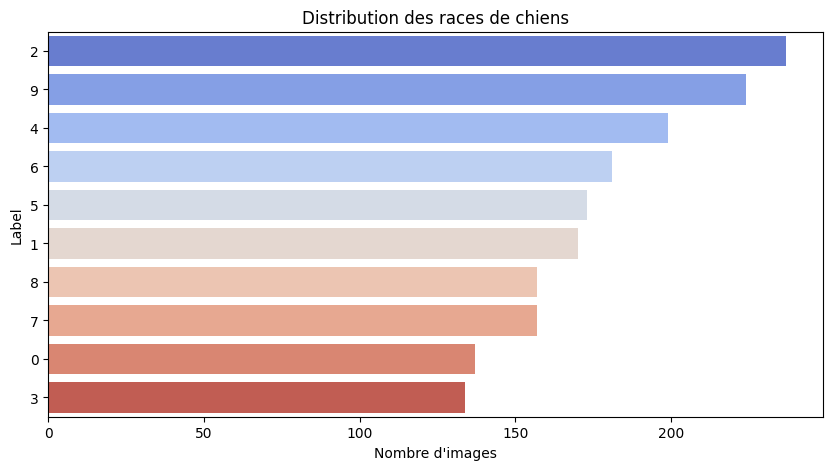

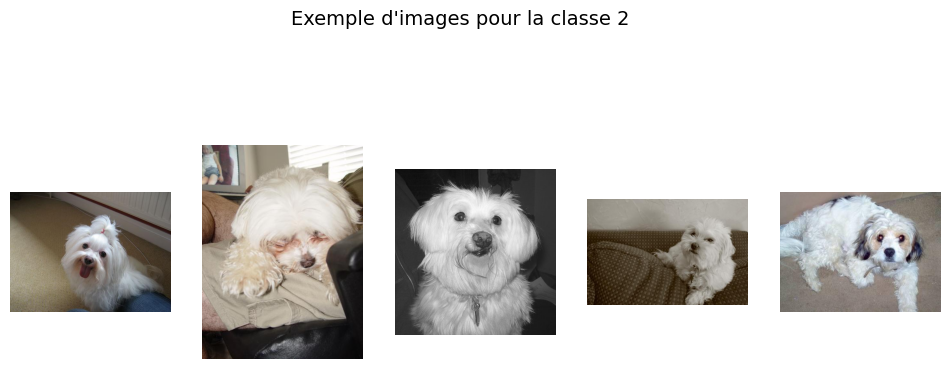

In [9]:
# 📌 Vérification des labels
print(df_train.head())
print("\n🔍 Distribution unique des labels : ", df_train["breed"].unique())

# ⚠️ Vérification des erreurs (-1 signifie que certaines images n'ont pas de label valide)
if -1 in df_train["breed"].values:
    print("⚠️ Attention : Certaines images n'ont pas été associées à un label valide.")

# 📊 Distribution des races
plt.figure(figsize=(10, 5))
sns.countplot(data=df_train, y="breed", order=df_train["breed"].value_counts().index, palette="coolwarm")
plt.title("Distribution des races de chiens")
plt.xlabel("Nombre d'images")
plt.ylabel("Label")
plt.show()

# 🖼️ Panel d'images par classe
def plot_images_by_label(df, label, num_images=5):
    """Affiche un échantillon d'images pour une race donnée."""

    # 📂 Sélectionner les fichiers correspondant au label
    selected_images = df[df["breed"] == label]["filename"].values

    if len(selected_images) == 0:
        print(f"⚠️ Aucune image trouvée pour le label {label}.")
        return

    # 🏷️ Tirer des images aléatoires
    sample_images = np.random.choice(selected_images, size=min(num_images, len(selected_images)), replace=False)

    # 🖼️ Affichage des images
    fig, axes = plt.subplots(1, len(sample_images), figsize=(12, 5))
    fig.suptitle(f"Exemple d'images pour la classe {label}", fontsize=14)

    for i, img_path in enumerate(sample_images):
        img = Image.open(img_path)  # Charger l'image
        axes[i].imshow(img)
        axes[i].axis("off")

    plt.show()

# 📌 Tester avec la classe la plus fréquente
most_common_label = df_train["breed"].value_counts().idxmax()
plot_images_by_label(df_train, most_common_label)

In [10]:
# 📊 Vérification des données avant le plot
print("📌 Aperçu du DataFrame des races :")
print(df_train.head())
print("\n🔍 Distribution unique des labels : ", df_train["breed"].unique())

📌 Aperçu du DataFrame des races :
                               filename  breed
0  data_split/train\n02085620_10074.jpg      0
1  data_split/train\n02085620_10131.jpg      0
2  data_split/train\n02085620_10621.jpg      0
3   data_split/train\n02085620_1073.jpg      0
4  data_split/train\n02085620_10976.jpg      0

🔍 Distribution unique des labels :  [0 1 2 3 4 5 6 7 8 9]


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1769 entries, 0 to 1768
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1769 non-null   object
 1   breed     1769 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.8+ KB


In [12]:
df_train.shape

(1769, 2)

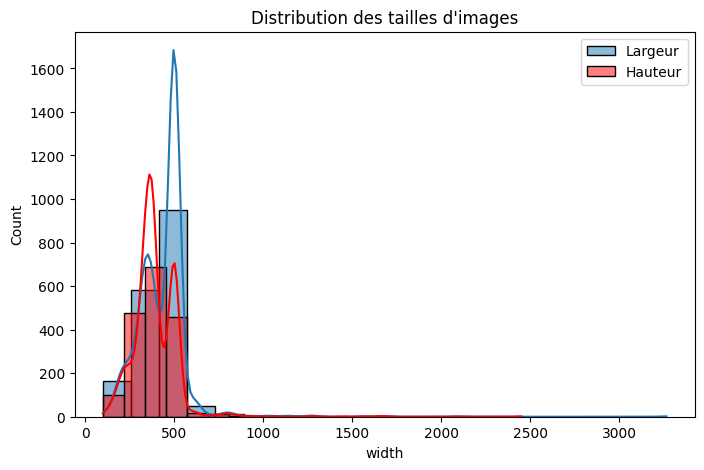

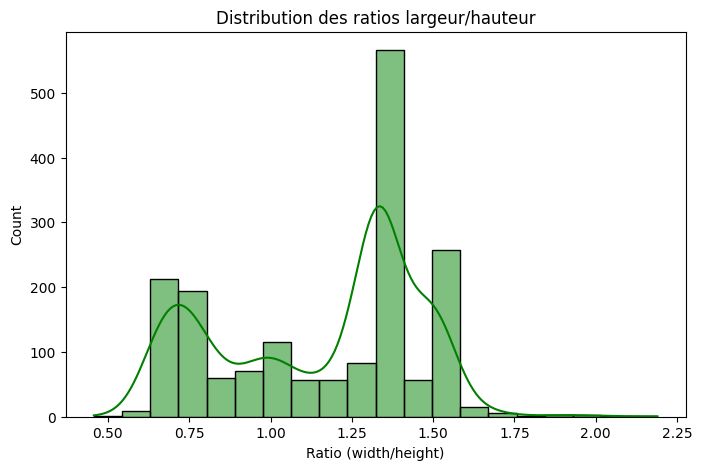

C:\Users\mathi\AppData\Local\Temp\ipykernel_24360\1980371977.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x="format", palette="pastel")


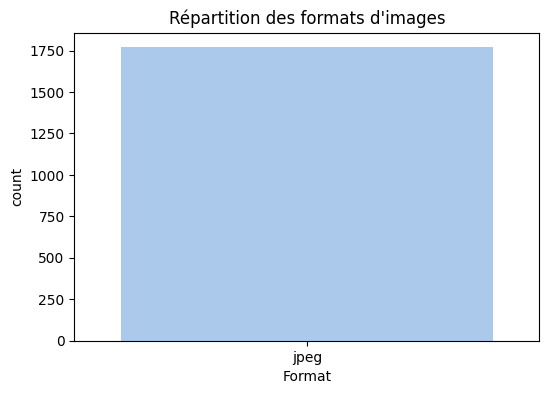

In [13]:
 # 📊 1. Extraction des tailles et formats d'image
image_sizes = []

for img_path in df_train["filename"]:
    try:
        with Image.open(img_path) as img:
            width, height = img.size
            img_format = img.format.lower()  # Convertir en minuscule (jpeg, png...)
            image_sizes.append((width, height, img_format))
    except Exception as e:
        print(f"⚠️ Erreur lors du chargement de {img_path}: {e}")
        image_sizes.append((None, None, None))  # Gérer les erreurs

# Ajout des nouvelles colonnes au DataFrame
df_train["width"], df_train["height"], df_train["format"] = zip(*image_sizes)

# Suppression des lignes avec valeurs manquantes
df_train = df_train.dropna(subset=["width", "height", "format"])

# 📊 2. Distribution des tailles d'images
plt.figure(figsize=(8, 5))
sns.histplot(df_train["width"], bins=20, kde=True, label="Largeur")
sns.histplot(df_train["height"], bins=20, kde=True, color="red", label="Hauteur")
plt.legend()
plt.title("Distribution des tailles d'images")
plt.show()

# 📊 3. Ratios largeur/hauteur
df_train["aspect_ratio"] = df_train["width"] / df_train["height"]

plt.figure(figsize=(8, 5))
sns.histplot(df_train["aspect_ratio"], bins=20, kde=True, color="green")
plt.title("Distribution des ratios largeur/hauteur")
plt.xlabel("Ratio (width/height)")
plt.show()

# 📊 4. Nombre d'images par format
plt.figure(figsize=(6, 4))
sns.countplot(data=df_train, x="format", palette="pastel")
plt.title("Répartition des formats d'images")
plt.xlabel("Format")
plt.show()

In [14]:
df_train.shape

(1769, 6)

In [15]:
print(img_path)

data_split/train\n02088094_988.jpg


In [16]:
class DogsDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df  # ✅ Stocker tout le DataFrame
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["filename"]  # ✅ Accéder au chemin depuis df
        label = self.df.iloc[idx]["breed"]  # ✅ Récupérer le label

        img = Image.open(img_path)
        if self.transforms:
            # for transform in self.transforms:
            img = self.transforms(img)

        return img, label


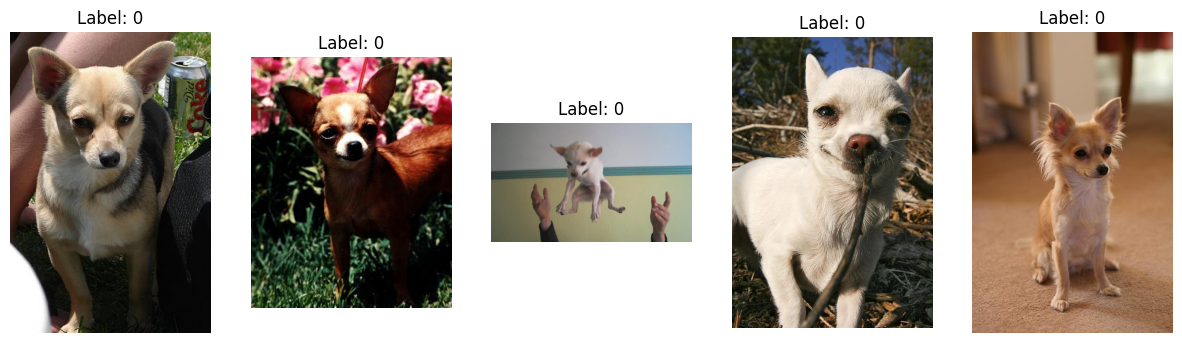

In [17]:
# ⚡ Création du dataset
dataset_train = DogsDataset(df_train)
dataset_test = DogsDataset(df_test)

# 📌 Affichage des 5 premières images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # 1 ligne, 5 colonnes

for i in range(5):
    img, label = dataset_train[i]  # Récupère image et label
    axes[i].imshow(img)  # Affichage avec Matplotlib
    axes[i].set_title(f"Label: {label}")  # Ajoute le label
    axes[i].axis("off")  # Cache les axes

plt.show()



In [18]:
print(df_train["breed"].value_counts())  # Vérifie combien d'images par label

breed
2    237
9    224
4    199
6    181
5    173
1    170
8    157
7    157
0    137
3    134
Name: count, dtype: int64


In [19]:
preprocessing = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        #transforms.GaussianBlur(3),
        transforms.ToTensor(),
    ]
)

In [20]:
data_augment = transforms.Compose(
    [
      transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
      transforms.RandomHorizontalFlip(0.5),
      transforms.RandomRotation(10),
      transforms.ToTensor(),
    ]
)


In [21]:
dataset_preprocessing_train = DogsDataset(df_train, transforms=preprocessing)

In [22]:
dataset_preprocessing_train

In [23]:
dataset_preprocessing_test = DogsDataset(df_test, transforms=preprocessing)

In [24]:
dataset_augment_train = DogsDataset(df_train, transforms=data_augment)

In [25]:
dataset_augment_test = DogsDataset(df_test, transforms=data_augment)

#Model Custom

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(32 * 26 * 26, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, num_classes)  # ✅ Ajusté dynamiquement

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Pas de softmax ici, car inclus dans la loss
        return x


In [27]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# Assurez-vous que votre DataLoader est correctement configuré
train_loader = DataLoader(dataset_preprocessing_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_preprocessing_test, batch_size=32, shuffle=False)

In [28]:
import torch
import torch.optim as optim

device = 'cuda'

# Si tu n'as pas encore créé le modèle, voici un exemple d'initialisation
model = CustomCNN(num_classes=len(df_train["breed"].unique())).to(device)

# Définir la fonction de perte et l'optimiseur
criterion = torch.nn.CrossEntropyLoss()  # Fonction de perte pour la classification multi-classes
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [29]:
# Définir le nombre d'époques
num_epochs = 20

# Dossier de sauvegarde
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialisation
best_accuracy = -float('inf')  # ou float('inf') pour suivre la loss
best_epoch = -1

# Entraînement du modèle
for epoch in range(num_epochs):
    model.train()  # Met le modèle en mode entraînement
    train_loss = 0.0

    # Utilisation de tqdm pour afficher la barre de progression pendant l'entraînement
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
        for inputs, labels in tepoch:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()  # Remet à zéro les gradients de l'optimiseur

            # Passage avant (forward)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calcul des gradients et mise à jour des poids
            loss.backward()
            optimizer.step()

            # Mise à jour de la barre de progression
            train_loss += loss.item()
            tepoch.set_postfix(loss=train_loss / (tepoch.n + 1))  # Afficher la moyenne des pertes

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss / len(train_loader):.4f}")

    # Validation du modèle après chaque époque
    model.eval()  # Met le modèle en mode évaluation
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Pas de calcul de gradients pendant la validation
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss / len(test_loader):.4f}, Accuracy: {val_accuracy:.2f}%")

    # Sauvegarde si le modèle est meilleur
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch + 1

        torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pth"))
        print(f"✅ Nouveau meilleur modèle sauvegardé à l'epoch {best_epoch} (accuracy = {best_accuracy:.4f})")

# Info finale
print(f"\n✅ Meilleur modèle obtenu à l'epoch {best_epoch} avec accuracy = {best_accuracy:.4f}")


Epoch 1/20: 100%|██████████| 56/56 [00:06<00:00,  8.03batch/s, loss=2.28]


Epoch 1/20 - Training Loss: 2.2805
Validation Loss: 2.2769, Accuracy: 16.00%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 1 (accuracy = 16.0000)


Epoch 2/20: 100%|██████████| 56/56 [00:06<00:00,  8.38batch/s, loss=2.21]


Epoch 2/20 - Training Loss: 2.2064
Validation Loss: 2.2137, Accuracy: 18.00%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 2 (accuracy = 18.0000)


Epoch 3/20: 100%|██████████| 56/56 [00:06<00:00,  8.41batch/s, loss=2.12]


Epoch 3/20 - Training Loss: 2.1238
Validation Loss: 2.1554, Accuracy: 22.00%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 3 (accuracy = 22.0000)


Epoch 4/20: 100%|██████████| 56/56 [00:06<00:00,  8.44batch/s, loss=2.04]


Epoch 4/20 - Training Loss: 2.0396
Validation Loss: 2.1134, Accuracy: 23.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 4 (accuracy = 23.3333)


Epoch 5/20: 100%|██████████| 56/56 [00:06<00:00,  8.32batch/s, loss=1.97]


Epoch 5/20 - Training Loss: 1.9659
Validation Loss: 2.0949, Accuracy: 24.67%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 5 (accuracy = 24.6667)


Epoch 6/20: 100%|██████████| 56/56 [00:06<00:00,  8.36batch/s, loss=1.9] 


Epoch 6/20 - Training Loss: 1.8966
Validation Loss: 2.0432, Accuracy: 24.67%


Epoch 7/20: 100%|██████████| 56/56 [00:06<00:00,  8.46batch/s, loss=1.83]


Epoch 7/20 - Training Loss: 1.8278
Validation Loss: 2.0188, Accuracy: 27.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 7 (accuracy = 27.3333)


Epoch 8/20: 100%|██████████| 56/56 [00:06<00:00,  8.46batch/s, loss=1.76]


Epoch 8/20 - Training Loss: 1.7588
Validation Loss: 1.9916, Accuracy: 28.67%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 8 (accuracy = 28.6667)


Epoch 9/20: 100%|██████████| 56/56 [00:06<00:00,  8.46batch/s, loss=1.7] 


Epoch 9/20 - Training Loss: 1.7029
Validation Loss: 1.9622, Accuracy: 28.67%


Epoch 10/20: 100%|██████████| 56/56 [00:06<00:00,  8.46batch/s, loss=1.64]


Epoch 10/20 - Training Loss: 1.6387
Validation Loss: 1.9455, Accuracy: 32.67%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 10 (accuracy = 32.6667)


Epoch 11/20: 100%|██████████| 56/56 [00:06<00:00,  8.49batch/s, loss=1.59]


Epoch 11/20 - Training Loss: 1.5872
Validation Loss: 1.9179, Accuracy: 32.00%


Epoch 12/20: 100%|██████████| 56/56 [00:06<00:00,  8.37batch/s, loss=1.53]


Epoch 12/20 - Training Loss: 1.5334
Validation Loss: 1.9194, Accuracy: 32.00%


Epoch 13/20: 100%|██████████| 56/56 [00:06<00:00,  8.41batch/s, loss=1.48]


Epoch 13/20 - Training Loss: 1.4824
Validation Loss: 1.9106, Accuracy: 31.33%


Epoch 14/20: 100%|██████████| 56/56 [00:06<00:00,  8.50batch/s, loss=1.43]


Epoch 14/20 - Training Loss: 1.4296
Validation Loss: 1.8913, Accuracy: 32.00%


Epoch 15/20: 100%|██████████| 56/56 [00:06<00:00,  8.43batch/s, loss=1.39]


Epoch 15/20 - Training Loss: 1.3855
Validation Loss: 1.8851, Accuracy: 32.67%


Epoch 16/20: 100%|██████████| 56/56 [00:06<00:00,  8.48batch/s, loss=1.34]


Epoch 16/20 - Training Loss: 1.3430
Validation Loss: 1.8682, Accuracy: 33.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 16 (accuracy = 33.3333)


Epoch 17/20: 100%|██████████| 56/56 [00:06<00:00,  8.38batch/s, loss=1.29]


Epoch 17/20 - Training Loss: 1.2903
Validation Loss: 1.8592, Accuracy: 34.00%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 17 (accuracy = 34.0000)


Epoch 18/20: 100%|██████████| 56/56 [00:06<00:00,  8.40batch/s, loss=1.25]


Epoch 18/20 - Training Loss: 1.2507
Validation Loss: 1.8620, Accuracy: 35.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 18 (accuracy = 35.3333)


Epoch 19/20: 100%|██████████| 56/56 [00:06<00:00,  8.34batch/s, loss=1.21]


Epoch 19/20 - Training Loss: 1.2055
Validation Loss: 1.8701, Accuracy: 32.67%


Epoch 20/20: 100%|██████████| 56/56 [00:06<00:00,  8.24batch/s, loss=1.16]


Epoch 20/20 - Training Loss: 1.1594
Validation Loss: 1.8521, Accuracy: 32.67%

✅ Meilleur modèle obtenu à l'epoch 18 avec accuracy = 35.3333


In [30]:
train_loader_augment = DataLoader(dataset_augment_train, batch_size=32, shuffle=True)
test_loader_augment = DataLoader(dataset_augment_test, batch_size=32, shuffle=False)

In [31]:
device = 'cuda'

# Si tu n'as pas encore créé le modèle, voici un exemple d'initialisation
model_augment = CustomCNN(num_classes=len(df_train["breed"].unique())).to(device)

# Définir la fonction de perte et l'optimiseur
criterion = torch.nn.CrossEntropyLoss()  # Fonction de perte pour la classification multi-classes
optimizer = optim.Adam(model_augment.parameters(), lr=1e-5)

In [32]:
# Définir le nombre d'époques
num_epochs = 20

# Dossier de sauvegarde
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialisation
best_accuracy = -float('inf')  # ou float('inf') pour suivre la loss
best_epoch = -1

# Entraînement du modèle
for epoch in range(num_epochs):
    model_augment.train()  # Met le modèle en mode entraînement
    train_loss = 0.0

    # Utilisation de tqdm pour afficher la barre de progression pendant l'entraînement
    with tqdm(train_loader_augment, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
        for inputs, labels in tepoch:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()  # Remet à zéro les gradients de l'optimiseur

            # Passage avant (forward)
            outputs = model_augment(inputs)
            loss = criterion(outputs, labels)

            # Calcul des gradients et mise à jour des poids
            loss.backward()
            optimizer.step()

            # Mise à jour de la barre de progression
            train_loss += loss.item()
            tepoch.set_postfix(loss=train_loss / (tepoch.n + 1))  # Afficher la moyenne des pertes

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss / len(train_loader_augment):.4f}")

    # Validation du modèle après chaque époque
    model_augment.eval()  # Met le modèle en mode évaluation
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Pas de calcul de gradients pendant la validation
        for inputs, labels in test_loader_augment:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_augment(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss / len(test_loader_augment):.4f}, Accuracy: {val_accuracy:.2f}%")

    # Sauvegarde si le modèle est meilleur
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch + 1

        torch.save(model_augment.state_dict(), os.path.join(checkpoint_dir, "best_model_augment.pth"))
        print(f"✅ Nouveau meilleur modèle sauvegardé à l'epoch {best_epoch} (accuracy = {best_accuracy:.4f})")

# Info finale
print(f"\n✅ Meilleur modèle obtenu à l'epoch {best_epoch} avec accuracy = {best_accuracy:.4f}")


Epoch 1/20: 100%|██████████| 56/56 [00:07<00:00,  7.43batch/s, loss=2.27]


Epoch 1/20 - Training Loss: 2.2727
Validation Loss: 2.2703, Accuracy: 12.67%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 1 (accuracy = 12.6667)


Epoch 2/20: 100%|██████████| 56/56 [00:07<00:00,  7.48batch/s, loss=2.21]


Epoch 2/20 - Training Loss: 2.2092
Validation Loss: 2.1822, Accuracy: 20.00%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 2 (accuracy = 20.0000)


Epoch 3/20: 100%|██████████| 56/56 [00:07<00:00,  7.56batch/s, loss=2.14]


Epoch 3/20 - Training Loss: 2.1444
Validation Loss: 2.1300, Accuracy: 23.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 3 (accuracy = 23.3333)


Epoch 4/20: 100%|██████████| 56/56 [00:07<00:00,  7.58batch/s, loss=2.09]


Epoch 4/20 - Training Loss: 2.0877
Validation Loss: 2.1119, Accuracy: 21.33%


Epoch 5/20: 100%|██████████| 56/56 [00:07<00:00,  7.54batch/s, loss=2.05]


Epoch 5/20 - Training Loss: 2.0523
Validation Loss: 2.0472, Accuracy: 24.67%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 5 (accuracy = 24.6667)


Epoch 6/20: 100%|██████████| 56/56 [00:07<00:00,  7.56batch/s, loss=2]   


Epoch 6/20 - Training Loss: 2.0041
Validation Loss: 2.0126, Accuracy: 28.67%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 6 (accuracy = 28.6667)


Epoch 7/20: 100%|██████████| 56/56 [00:07<00:00,  7.52batch/s, loss=1.96]


Epoch 7/20 - Training Loss: 1.9631
Validation Loss: 1.9874, Accuracy: 32.00%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 7 (accuracy = 32.0000)


Epoch 8/20: 100%|██████████| 56/56 [00:07<00:00,  7.58batch/s, loss=1.93]


Epoch 8/20 - Training Loss: 1.9309
Validation Loss: 1.9898, Accuracy: 30.67%


Epoch 9/20: 100%|██████████| 56/56 [00:07<00:00,  7.54batch/s, loss=1.9] 


Epoch 9/20 - Training Loss: 1.9004
Validation Loss: 1.9708, Accuracy: 29.33%


Epoch 10/20: 100%|██████████| 56/56 [00:07<00:00,  7.51batch/s, loss=1.88]


Epoch 10/20 - Training Loss: 1.8803
Validation Loss: 1.9360, Accuracy: 31.33%


Epoch 11/20: 100%|██████████| 56/56 [00:07<00:00,  7.60batch/s, loss=1.84]


Epoch 11/20 - Training Loss: 1.8420
Validation Loss: 1.9524, Accuracy: 30.00%


Epoch 12/20: 100%|██████████| 56/56 [00:07<00:00,  7.53batch/s, loss=1.82]


Epoch 12/20 - Training Loss: 1.8225
Validation Loss: 1.9292, Accuracy: 33.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 12 (accuracy = 33.3333)


Epoch 13/20: 100%|██████████| 56/56 [00:07<00:00,  7.49batch/s, loss=1.8] 


Epoch 13/20 - Training Loss: 1.8043
Validation Loss: 1.8985, Accuracy: 32.67%


Epoch 14/20: 100%|██████████| 56/56 [00:07<00:00,  7.59batch/s, loss=1.78]


Epoch 14/20 - Training Loss: 1.7777
Validation Loss: 1.9496, Accuracy: 30.67%


Epoch 15/20: 100%|██████████| 56/56 [00:07<00:00,  7.64batch/s, loss=1.76]


Epoch 15/20 - Training Loss: 1.7621
Validation Loss: 1.8979, Accuracy: 33.33%


Epoch 16/20: 100%|██████████| 56/56 [00:07<00:00,  7.59batch/s, loss=1.75]


Epoch 16/20 - Training Loss: 1.7502
Validation Loss: 1.9138, Accuracy: 30.00%


Epoch 17/20: 100%|██████████| 56/56 [00:07<00:00,  7.62batch/s, loss=1.73]


Epoch 17/20 - Training Loss: 1.7293
Validation Loss: 1.9436, Accuracy: 32.67%


Epoch 18/20: 100%|██████████| 56/56 [00:07<00:00,  7.45batch/s, loss=1.71]


Epoch 18/20 - Training Loss: 1.7138
Validation Loss: 1.8998, Accuracy: 32.00%


Epoch 19/20: 100%|██████████| 56/56 [00:07<00:00,  7.58batch/s, loss=1.7] 


Epoch 19/20 - Training Loss: 1.6967
Validation Loss: 1.8840, Accuracy: 30.67%


Epoch 20/20: 100%|██████████| 56/56 [00:07<00:00,  7.50batch/s, loss=1.7] 


Epoch 20/20 - Training Loss: 1.7000
Validation Loss: 1.8783, Accuracy: 36.67%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 20 (accuracy = 36.6667)

✅ Meilleur modèle obtenu à l'epoch 20 avec accuracy = 36.6667


#Transfert learning

In [33]:
preprocessing_transfert = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        #transforms.GaussianBlur(3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ImageNet
    ]
)

In [34]:
data_augment_transfert = transforms.Compose(
    [
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ImageNet
    ]
)


In [35]:
preprocessing_transfert_train = DogsDataset(df_train, transforms=preprocessing_transfert)
preprocessing_transfert_test = DogsDataset(df_test, transforms=preprocessing_transfert)

In [36]:
augmentation_transfert_train = DogsDataset(df_train, transforms=data_augment_transfert)
augmentation_transfert_test = DogsDataset(df_test, transforms=data_augment_transfert)

In [37]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# Assurez-vous que votre DataLoader est correctement configuré
transfert_train_loader = DataLoader(preprocessing_transfert_train, batch_size=32, shuffle=True)
transfert_test_loader = DataLoader(preprocessing_transfert_test, batch_size=32, shuffle=False)

In [38]:
# Récupérer un batch d'images
data_iter = iter(transfert_train_loader)
images, labels = next(data_iter)

# Vérifier la taille des images
print(f"Taille du batch : {images.shape}")  # Doit être (batch_size, 3, 224, 224)

Taille du batch : torch.Size([32, 3, 224, 224])


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

# 📌 Charger VGG16 pré-entraîné
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_transfert = models.vgg16(pretrained=True)

# 🔄 Modifier la dernière couche (10 classes)
num_classes = 10
model_transfert.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

# ⚙️ Geler les couches convolutionnelles
for param in model_transfert.features.parameters():
    param.requires_grad = False

model_transfert = model_transfert.to(device)

# 🎯 Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_transfert.classifier.parameters(), lr=0.0001)


c:\Users\mathi\miniconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mathi\miniconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
# 🚀 Entraînement du modèle
num_epochs = 20

# Dossier de sauvegarde
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialisation
best_accuracy = -float('inf')  # ou float('inf') pour suivre la loss
best_epoch = -1

for epoch in range(num_epochs):
    model_transfert.train()
    train_loss = 0.0

    with tqdm(transfert_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
      for inputs, labels in tepoch:
        inputs = inputs.to(device)
        labels = labels.to(device) if isinstance(labels, torch.Tensor) else torch.tensor(labels, dtype=torch.long, device=device)

        optimizer.zero_grad()  # Remet à zéro les gradients de l'optimiseur

        outputs = model_transfert(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        tepoch.set_postfix(loss=train_loss / (tepoch.n + 1))

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(transfert_train_loader):.4f}")

    # 🔎 Évaluation
    model_transfert.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in transfert_test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device) if isinstance(labels, torch.Tensor) else torch.tensor(labels, dtype=torch.long, device=device)

          outputs = model_transfert(inputs)
          loss = criterion(outputs, labels)

          val_loss += loss.item()
          _, predicted = outputs.max(1)
          correct += (predicted == labels).sum().item()
          total += labels.size(0)

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss / len(transfert_test_loader):.4f}, Accuracy: {val_accuracy:.2f}%")

    # Sauvegarde si le modèle est meilleur
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch + 1

        torch.save(model_transfert.state_dict(), os.path.join(checkpoint_dir, "best_model_transfert.pth"))
        print(f"✅ Nouveau meilleur modèle sauvegardé à l'epoch {best_epoch} (accuracy = {best_accuracy:.4f})")

# Info finale
print(f"\n✅ Meilleur modèle obtenu à l'epoch {best_epoch} avec accuracy = {best_accuracy:.4f}")

Epoch 1/20: 100%|██████████| 56/56 [00:15<00:00,  3.64batch/s, loss=0.567]


Epoch 1/20, Loss: 0.5674
Validation Loss: 0.2224, Accuracy: 91.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 1 (accuracy = 91.3333)


Epoch 2/20: 100%|██████████| 56/56 [00:15<00:00,  3.62batch/s, loss=0.113]


Epoch 2/20, Loss: 0.1129
Validation Loss: 0.2153, Accuracy: 93.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 2 (accuracy = 93.3333)


Epoch 3/20: 100%|██████████| 56/56 [00:15<00:00,  3.67batch/s, loss=0.0297]


Epoch 3/20, Loss: 0.0297
Validation Loss: 0.2614, Accuracy: 92.67%


Epoch 4/20: 100%|██████████| 56/56 [00:15<00:00,  3.71batch/s, loss=0.0162]


Epoch 4/20, Loss: 0.0162
Validation Loss: 0.2082, Accuracy: 92.67%


Epoch 5/20: 100%|██████████| 56/56 [00:15<00:00,  3.71batch/s, loss=0.0128]


Epoch 5/20, Loss: 0.0128
Validation Loss: 0.3032, Accuracy: 92.67%


Epoch 6/20: 100%|██████████| 56/56 [00:15<00:00,  3.72batch/s, loss=0.00689]


Epoch 6/20, Loss: 0.0069
Validation Loss: 0.3027, Accuracy: 92.67%


Epoch 7/20: 100%|██████████| 56/56 [00:15<00:00,  3.68batch/s, loss=0.00889]


Epoch 7/20, Loss: 0.0089
Validation Loss: 0.3533, Accuracy: 90.00%


Epoch 8/20: 100%|██████████| 56/56 [00:15<00:00,  3.61batch/s, loss=0.00738]


Epoch 8/20, Loss: 0.0074
Validation Loss: 0.2968, Accuracy: 92.00%


Epoch 9/20: 100%|██████████| 56/56 [00:15<00:00,  3.68batch/s, loss=0.00451] 


Epoch 9/20, Loss: 0.0045
Validation Loss: 0.4641, Accuracy: 91.33%


Epoch 10/20: 100%|██████████| 56/56 [00:15<00:00,  3.68batch/s, loss=0.0057] 


Epoch 10/20, Loss: 0.0057
Validation Loss: 0.4827, Accuracy: 92.00%


Epoch 11/20: 100%|██████████| 56/56 [00:15<00:00,  3.66batch/s, loss=0.00366]


Epoch 11/20, Loss: 0.0037
Validation Loss: 0.4675, Accuracy: 92.00%


Epoch 12/20: 100%|██████████| 56/56 [00:15<00:00,  3.65batch/s, loss=0.00107] 


Epoch 12/20, Loss: 0.0011
Validation Loss: 0.4857, Accuracy: 90.67%


Epoch 13/20: 100%|██████████| 56/56 [00:15<00:00,  3.64batch/s, loss=0.000603]


Epoch 13/20, Loss: 0.0006
Validation Loss: 0.5080, Accuracy: 92.67%


Epoch 14/20: 100%|██████████| 56/56 [00:15<00:00,  3.68batch/s, loss=0.000387]


Epoch 14/20, Loss: 0.0004
Validation Loss: 0.4930, Accuracy: 91.33%


Epoch 15/20: 100%|██████████| 56/56 [00:15<00:00,  3.65batch/s, loss=0.000256]


Epoch 15/20, Loss: 0.0003
Validation Loss: 0.4658, Accuracy: 92.67%


Epoch 16/20: 100%|██████████| 56/56 [00:15<00:00,  3.64batch/s, loss=0.0046]  


Epoch 16/20, Loss: 0.0046
Validation Loss: 0.5256, Accuracy: 90.00%


Epoch 17/20: 100%|██████████| 56/56 [00:15<00:00,  3.69batch/s, loss=0.0229] 


Epoch 17/20, Loss: 0.0229
Validation Loss: 0.6425, Accuracy: 90.00%


Epoch 18/20: 100%|██████████| 56/56 [00:15<00:00,  3.67batch/s, loss=0.00966]


Epoch 18/20, Loss: 0.0097
Validation Loss: 0.4835, Accuracy: 90.00%


Epoch 19/20: 100%|██████████| 56/56 [00:15<00:00,  3.67batch/s, loss=0.0242] 


Epoch 19/20, Loss: 0.0242
Validation Loss: 0.4755, Accuracy: 91.33%


Epoch 20/20: 100%|██████████| 56/56 [00:15<00:00,  3.66batch/s, loss=0.0359] 


Epoch 20/20, Loss: 0.0359
Validation Loss: 0.8938, Accuracy: 90.00%

✅ Meilleur modèle obtenu à l'epoch 2 avec accuracy = 93.3333


In [41]:
# Assurez-vous que votre DataLoader est correctement configuré
transfert_augment_train_loader = DataLoader(augmentation_transfert_train, batch_size=32, shuffle=True)
transfert_augment_test_loader = DataLoader(augmentation_transfert_test, batch_size=32, shuffle=False)

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

# 📌 Charger VGG16 pré-entraîné
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_transfert_augment = models.vgg16(pretrained=True)

# 🔄 Modifier la dernière couche (10 classes)
num_classes = 10
model_transfert_augment.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

# ⚙️ Geler les couches convolutionnelles
for param in model_transfert_augment.features.parameters():
    param.requires_grad = False

model_transfert_augment = model_transfert_augment.to(device)

# 🎯 Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_transfert_augment.classifier.parameters(), lr=0.0001)


In [43]:
# 🚀 Entraînement du modèle
num_epochs = 20

# Dossier de sauvegarde
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialisation
best_accuracy = -float('inf')  # ou float('inf') pour suivre la loss
best_epoch = -1


for epoch in range(num_epochs):
    model_transfert_augment.train()
    train_loss = 0.0

    with tqdm(transfert_augment_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
      for inputs, labels in tepoch:
        inputs = inputs.to(device)
        labels = labels.to(device) if isinstance(labels, torch.Tensor) else torch.tensor(labels, dtype=torch.long, device=device)

        optimizer.zero_grad()  # Remet à zéro les gradients de l'optimiseur

        outputs = model_transfert_augment(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        tepoch.set_postfix(loss=train_loss / (tepoch.n + 1))

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(transfert_augment_train_loader):.4f}")

    # 🔎 Évaluation
    model_transfert_augment.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in transfert_augment_test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device) if isinstance(labels, torch.Tensor) else torch.tensor(labels, dtype=torch.long, device=device)

          outputs = model_transfert_augment(inputs)
          loss = criterion(outputs, labels)

          val_loss += loss.item()
          _, predicted = outputs.max(1)
          correct += (predicted == labels).sum().item()
          total += labels.size(0)

    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss / len(transfert_augment_test_loader):.4f}, Accuracy: {val_accuracy:.2f}%")

    # Sauvegarde si le modèle est meilleur
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch + 1

        torch.save(model_transfert_augment.state_dict(), os.path.join(checkpoint_dir, "best_model_transfert_augment.pth"))
        print(f"✅ Nouveau meilleur modèle sauvegardé à l'epoch {best_epoch} (accuracy = {best_accuracy:.4f})")

# Info finale
print(f"\n✅ Meilleur modèle obtenu à l'epoch {best_epoch} avec accuracy = {best_accuracy:.4f}")

Epoch 1/20: 100%|██████████| 56/56 [00:16<00:00,  3.48batch/s, loss=0.616]


Epoch 1/20, Loss: 0.6156
Validation Loss: 0.2483, Accuracy: 92.00%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 1 (accuracy = 92.0000)


Epoch 2/20: 100%|██████████| 56/56 [00:16<00:00,  3.42batch/s, loss=0.208]


Epoch 2/20, Loss: 0.2082
Validation Loss: 0.2749, Accuracy: 92.00%


Epoch 3/20: 100%|██████████| 56/56 [00:16<00:00,  3.46batch/s, loss=0.145]


Epoch 3/20, Loss: 0.1451
Validation Loss: 0.2810, Accuracy: 92.00%


Epoch 4/20: 100%|██████████| 56/56 [00:16<00:00,  3.44batch/s, loss=0.142] 


Epoch 4/20, Loss: 0.1420
Validation Loss: 0.2240, Accuracy: 93.33%
✅ Nouveau meilleur modèle sauvegardé à l'epoch 4 (accuracy = 93.3333)


Epoch 5/20: 100%|██████████| 56/56 [00:16<00:00,  3.46batch/s, loss=0.0973]


Epoch 5/20, Loss: 0.0973
Validation Loss: 0.3234, Accuracy: 92.00%


Epoch 6/20: 100%|██████████| 56/56 [00:16<00:00,  3.45batch/s, loss=0.0789]


Epoch 6/20, Loss: 0.0789
Validation Loss: 0.3536, Accuracy: 91.33%


Epoch 7/20: 100%|██████████| 56/56 [00:16<00:00,  3.43batch/s, loss=0.0593]


Epoch 7/20, Loss: 0.0593
Validation Loss: 0.4157, Accuracy: 90.00%


Epoch 8/20: 100%|██████████| 56/56 [00:16<00:00,  3.41batch/s, loss=0.0559]


Epoch 8/20, Loss: 0.0559
Validation Loss: 0.4139, Accuracy: 89.33%


Epoch 9/20: 100%|██████████| 56/56 [00:16<00:00,  3.48batch/s, loss=0.068] 


Epoch 9/20, Loss: 0.0680
Validation Loss: 0.4626, Accuracy: 89.33%


Epoch 10/20: 100%|██████████| 56/56 [00:16<00:00,  3.32batch/s, loss=0.0516]


Epoch 10/20, Loss: 0.0516
Validation Loss: 0.4939, Accuracy: 92.67%


Epoch 11/20: 100%|██████████| 56/56 [00:17<00:00,  3.25batch/s, loss=0.0387]


Epoch 11/20, Loss: 0.0387
Validation Loss: 0.5859, Accuracy: 92.67%


Epoch 12/20: 100%|██████████| 56/56 [00:17<00:00,  3.23batch/s, loss=0.0611]


Epoch 12/20, Loss: 0.0611
Validation Loss: 0.4596, Accuracy: 90.00%


Epoch 13/20: 100%|██████████| 56/56 [00:17<00:00,  3.24batch/s, loss=0.0371] 


Epoch 13/20, Loss: 0.0371
Validation Loss: 0.4193, Accuracy: 91.33%


Epoch 14/20: 100%|██████████| 56/56 [00:17<00:00,  3.22batch/s, loss=0.0392]


Epoch 14/20, Loss: 0.0392
Validation Loss: 0.4868, Accuracy: 91.33%


Epoch 15/20: 100%|██████████| 56/56 [00:17<00:00,  3.16batch/s, loss=0.0356]


Epoch 15/20, Loss: 0.0356
Validation Loss: 0.2941, Accuracy: 93.33%


Epoch 16/20: 100%|██████████| 56/56 [00:17<00:00,  3.21batch/s, loss=0.0507]


Epoch 16/20, Loss: 0.0507
Validation Loss: 0.5033, Accuracy: 92.67%


Epoch 17/20: 100%|██████████| 56/56 [00:17<00:00,  3.29batch/s, loss=0.0345]


Epoch 17/20, Loss: 0.0345
Validation Loss: 0.6437, Accuracy: 90.67%


Epoch 18/20: 100%|██████████| 56/56 [00:16<00:00,  3.31batch/s, loss=0.0319]


Epoch 18/20, Loss: 0.0319
Validation Loss: 0.6224, Accuracy: 90.00%


Epoch 19/20: 100%|██████████| 56/56 [00:17<00:00,  3.24batch/s, loss=0.0224]


Epoch 19/20, Loss: 0.0224
Validation Loss: 0.6409, Accuracy: 87.33%


Epoch 20/20: 100%|██████████| 56/56 [00:17<00:00,  3.27batch/s, loss=0.038] 


Epoch 20/20, Loss: 0.0380
Validation Loss: 0.5215, Accuracy: 90.00%

✅ Meilleur modèle obtenu à l'epoch 4 avec accuracy = 93.3333
